In [10]:
import pandas as pd
import h3.api.numpy_int as h3

import matplotlib.pyplot as plt
import cartopy.io.shapereader as shpreader
import geopandas as gpd
from shapely.geometry import Polygon, Point
import seaborn as sns

import stc_unicef_cpi.data.get_satellite_data as ge
import stc_unicef_cpi.data.make_dataset as md
import stc_unicef_cpi.utils.general as g
import stc_unicef_cpi.utils.constants as c

import stc_unicef_cpi.utils.geospatial as geo
import stc_unicef_cpi.utils.clean_text as ct

# Years of DHS surveys

In [2]:
raw = pd.read_csv('/mnt/c/Users/vicin/Desktop/DSSG/Project/stc_continuing/data/raw/childpoverty_microdata_gps_21jun22.csv')

/tmp/ipykernel_354/3558682085.py:1: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  raw = pd.read_csv('/mnt/c/Users/vicin/Desktop/DSSG/Project/stc_continuing/data/raw/childpoverty_microdata_gps_21jun22.csv')


In [12]:
countries_ssf = ['Angola', 
            'Benin', 'Botswana', 'Burkina Faso', 'Burundi',
            'Cabo Verde', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Congo, The Democratic Republic of the', 'Congo', "Côte d'Ivoire",
            'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia', 
            'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau',
            'Kenya', 
            'Lesotho', 'Liberia', 
            'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Mozambique',
            'Namibia', 'Niger', 'Nigeria',
            'Rwanda', 
            'Sao Tome and Principe', 'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa', 'Sudan', 'South Sudan', 
            'Tanzania, United Republic of', 'Togo', 
            'Uganda',
            'Zambia', 'Zimbabwe']

In [16]:
countries_dhs = pd.DataFrame(columns=['country', 'country_code', 'dhs_children', 'dhs_year', 'mics_children', 'mics_year'])

for country in countries_ssf:
    country_code = ct.get_alpha3_code(country)

    if country_code in list(raw['countrycode']):
        subset = raw[raw['countrycode']==country_code]
        # print('check if there are nan values')
        # print(subset['deprived_sev'].value_counts())
        dhs = subset[subset.survey=='DHS']
        if dhs.shape[0]!= 0:
            year_dhs = dhs.year.mean()
            num_dhs = dhs.shape[0]
        else:
            year_dhs, num_dhs = 0, 0

        mics = subset[subset.survey=='MICS']
        if mics.shape[0]!= 0:
            year_mics = mics.year.mean()
            num_mics = mics.shape[0]
        else:
            year_mics, num_mics = 0, 0

        countries_dhs = countries_dhs.append({'country':country,  'country_code':country_code, 'dhs_children': num_dhs, 'dhs_year':year_dhs, 
                    'mics_children':  num_mics,   'mics_year': year_mics}, ignore_index=True)
    
        

In [19]:
country_mics = countries_dhs[countries_dhs['mics_children']!= 0].copy()
countries_dhs = countries_dhs[countries_dhs['dhs_children']!= 0].copy()

In [23]:
country_mics

,country,country_code,dhs_children,dhs_year,mics_children,mics_year
5,Central African Republic,CAF,0,0.0,25430,2019.0
6,Chad,TCD,0,0.0,67164,2019.0
8,"Congo, The Democratic Republic of the",COD,53868,2013.0,57566,2018.0
9,Congo,COG,0,0.0,26691,2015.0
10,Côte d'Ivoire,CIV,0,0.0,28377,2016.0
11,Eswatini,SWZ,0,0.0,10131,2014.0
13,Gambia,GMB,0,0.0,32786,2018.0
14,Ghana,GHA,0,0.0,30663,2017.0
16,Guinea-Bissau,GNB,0,0.0,24206,2019.0
18,Lesotho,LSO,16898,2014.0,13989,2018.0


In [14]:
# countries_dhs = pd.read_csv('/mnt/c/Users/vicin/Desktop/DSSG/Data/Tables tesi/countries_with_output.csv', dtype = {'DHS year':int})
# countries_dhs = countries_dhs.rename(columns = {'Country':'country', 'Code':'country_code', 'DHS year':'dhs_year', 'Number of children with DHS':'dhs_children'})
countries_dhs.head(3)

,country,country_code,dhs_children,dhs_year,num hex with output,num hex with neigh,tot
0,Angola,AGO,42167,2015,519,6050,220183
1,Benin,BEN,40064,2017,475,5065,28345
2,Burkina Faso,BFA,44464,2010,501,7154,67132


In [38]:
# ctry_code = ct.get_alpha3_code('')
shpfilename = shpreader.natural_earth(
        resolution="10m", category="cultural", name="admin_0_countries"
    )

# read the shapefile using geopandas
world = gpd.read_file(shpfilename)

# select countries in Africa
africa = world[world['CONTINENT'] == "Africa"]

In [4]:
africa.head(2)

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
13,Admin-0 country,0,2,Ethiopia,ETH,0,2,Sovereign country,1,Ethiopia,...,None,None,None,None,None,None,None,None,None,"POLYGON ((34.07070 9.45459, 34.06689 9.53118, ..."
14,Admin-0 country,0,3,South Sudan,SDS,0,2,Sovereign country,1,South Sudan,...,None,None,None,None,None,None,None,None,None,"POLYGON ((35.92084 4.61933, 35.85654 4.61960, ..."


In [5]:
to_plot = africa.merge(countries_dhs, how='left', right_on = 'country_code', left_on = 'ADM0_ISO')
to_plot = to_plot[to_plot.country_code.isna()==False].copy()
to_plot['dhs_year'] = to_plot['dhs_year'].apply(lambda x: int(x))
print(to_plot.shape)

(25, 176)


In [6]:
sorted(to_plot.dhs_year.unique())

[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

Countries with DHS surveys and the latest year it was done


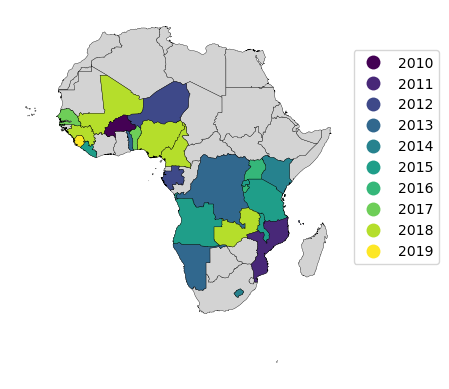

In [7]:
fig, ax = plt.subplots()# dpi=300)
ax.axis('off')

africa.plot(ax=ax, edgecolor="black", facecolor='lightgray', lw=0.25) 

print('Countries with DHS surveys and the latest year it was done')
_ = to_plot.plot(ax=ax, edgecolor="black", cmap = 'viridis', column = 'dhs_year',  lw=0.25, 
            categorical=True, legend=True,
            legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.6),
                         'fmt': "{:.0f}"}) 



Children surveys per country


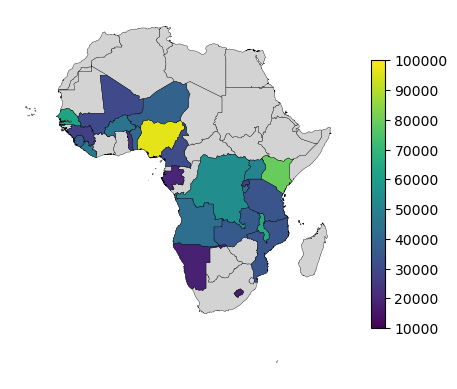

In [8]:
fig, ax = plt.subplots()# dpi=300)
ax.axis('off')

africa.plot(ax=ax, edgecolor="black", facecolor='lightgray', lw=0.25) 

vmin, vmax = 10000, 100000

print('Children surveys per country')
_ = to_plot.plot(ax=ax, edgecolor="black", cmap = 'viridis', column = 'dhs_children',  lw=0.25, vmin = vmin, vmax = vmax, 
            # legend=True,
            # legend_kwds={"shrink":.9},
            )

sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, fraction=0.027)


# Correlation between dimensions

In [3]:
read_path = '/mnt/c/Users/vicin/Desktop/DSSG/Project/stc_continuing/data/processed'

In [4]:
hexes_dhs = pd.read_csv(read_path + '/20221025_hexes_dhs.csv', dtype={'hex_code':int})

/tmp/ipykernel_354/3041623803.py:1: DtypeWarning: Columns (154) have mixed types. Specify dtype option on import or set low_memory=False.
  hexes_dhs = pd.read_csv(read_path + '/20221025_hexes_dhs.csv', dtype={'hex_code':int})


In [5]:
hexes_dhs_no_neigh = hexes_dhs[hexes_dhs['deprived_sev'].isna()==False].copy()
hexes_dhs_no_neigh.shape

(12468, 155)

In [13]:
dimensions = ['sumpoor_sev', 'dep_housing_sev', 'dep_water_sev',
       'dep_sanitation_sev', 'dep_nutrition_sev', 'dep_health_sev',
       'dep_education_sev', 'deprived_sev']
labels = ['depth', 'housing', 'water', 'sanitation', 'nutrition', 'health', 'education', 'prevalence']

In [11]:
corr_no_neigh = hexes_dhs_no_neigh[dimensions].corr()

<AxesSubplot:>

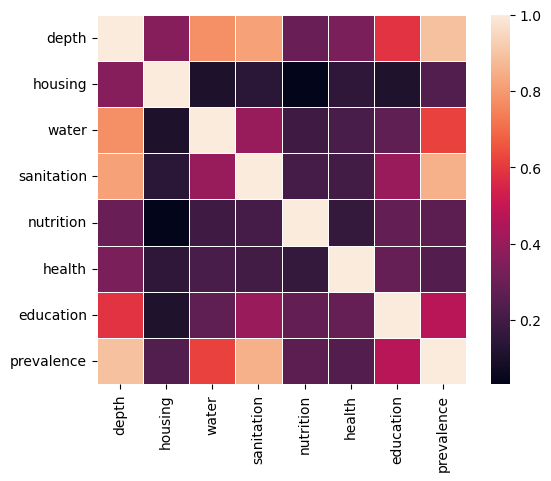

In [17]:
sns.heatmap(corr_no_neigh,
            square=True,
            xticklabels=labels, yticklabels=labels,
            linewidth=.5)